<a href="https://colab.research.google.com/github/VinceVence/aquaponics-handbook/blob/main/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification using Deep Convolutional Neural Networks and Transfer Learning

## Import Necessary Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# System libraries
from pathlib import Path
import os.path

In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

## Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-05-08 10:48:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-08 10:48:33 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Schematic Diagram

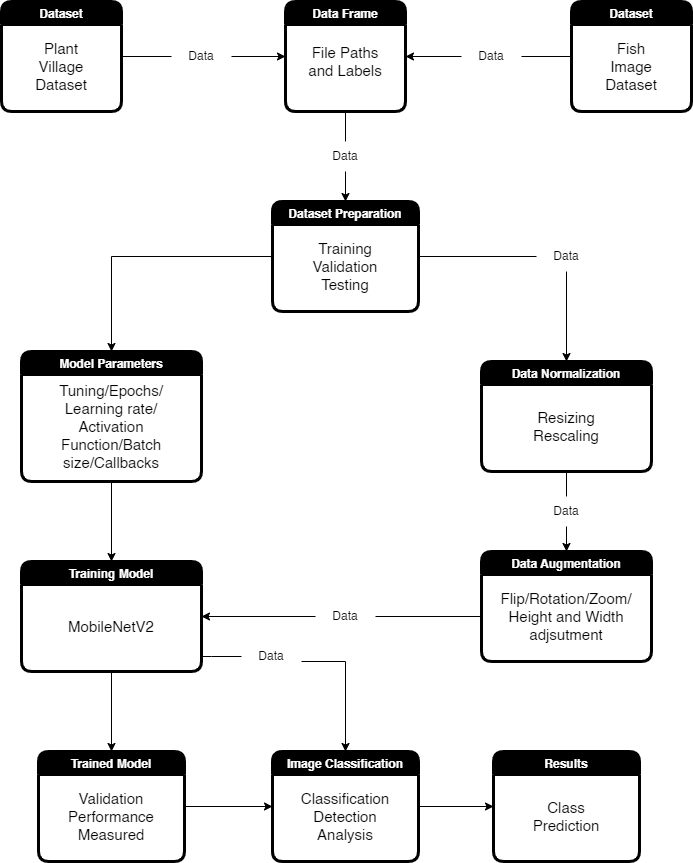

## Load and transform data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
# Unzip data from directory
unzip_data("/content/drive/MyDrive/Software Engineering 2/Tentative Datasets/PlantVillageDataset.zip")

In [ ]:
# Walk through each directory
dataset = "/content/plantvillage dataset/color"
walk_through_dir(dataset)

There are 38 directories and 0 images in '/content/plantvillage dataset/color'.
There are 0 directories and 621 images in '/content/plantvillage dataset/color/Apple___Black_rot'.
There are 0 directories and 1192 images in '/content/plantvillage dataset/color/Corn_(maize)___Common_rust_'.
There are 0 directories and 1052 images in '/content/plantvillage dataset/color/Cherry_(including_sour)___Powdery_mildew'.
There are 0 directories and 952 images in '/content/plantvillage dataset/color/Tomato___Leaf_Mold'.
There are 0 directories and 1000 images in '/content/plantvillage dataset/color/Potato___Early_blight'.
There are 0 directories and 1109 images in '/content/plantvillage dataset/color/Strawberry___Leaf_scorch'.
There are 0 directories and 1909 images in '/content/plantvillage dataset/color/Tomato___Late_blight'.
There are 0 directories and 630 images in '/content/plantvillage dataset/color/Apple___Apple_scab'.
There are 0 directories and 275 images in '/content/plantvillage dataset/c

### Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/plantvillage dataset/color/Apple___Bl...,Apple___Black_rot
1,/content/plantvillage dataset/color/Apple___Bl...,Apple___Black_rot
2,/content/plantvillage dataset/color/Apple___Bl...,Apple___Black_rot
3,/content/plantvillage dataset/color/Apple___Bl...,Apple___Black_rot
4,/content/plantvillage dataset/color/Apple___Bl...,Apple___Black_rot
...,...,...
54300,/content/plantvillage dataset/color/Squash___P...,Squash___Powdery_mildew
54301,/content/plantvillage dataset/color/Tomato___h...,Tomato___healthy
54302,"/content/plantvillage dataset/color/Pepper,_be...","Pepper,_bell___healthy"
54303,"/content/plantvillage dataset/color/Pepper,_be...","Pepper,_bell___healthy"


### Visualizing images from the dataset

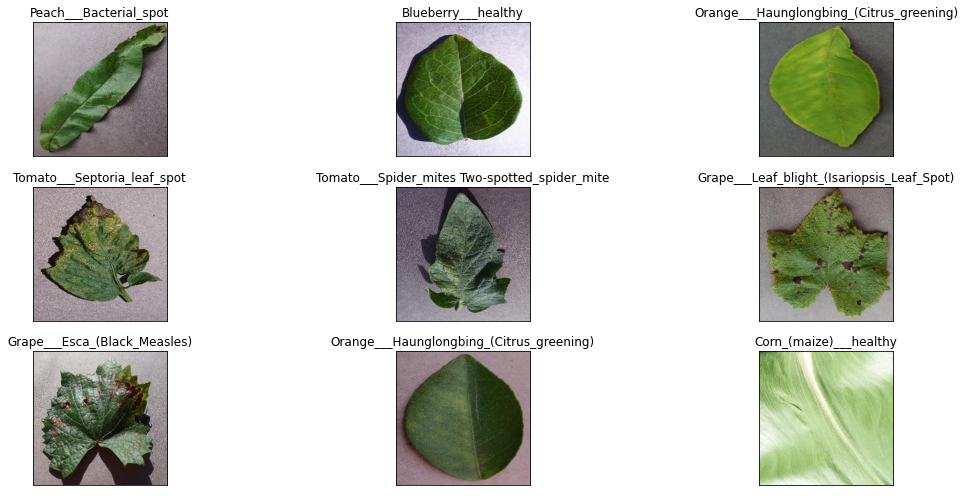

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 34756 validated image filenames belonging to 38 classes.
Found 8688 validated image filenames belonging to 38 classes.
Found 10861 validated image filenames belonging to 38 classes.


### Resizing and Data Augmentation

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.5),
  preprocessing.RandomZoom(0.5),
  preprocessing.RandomHeight(0.5),
  preprocessing.RandomWidth(0.5),                       
], name="data_augmentation")

## Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 38



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Setting up callbacks

In [ ]:
# Create checkpoint callback
checkpoint_path = "fish_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

### Summary of the CNN model architecture
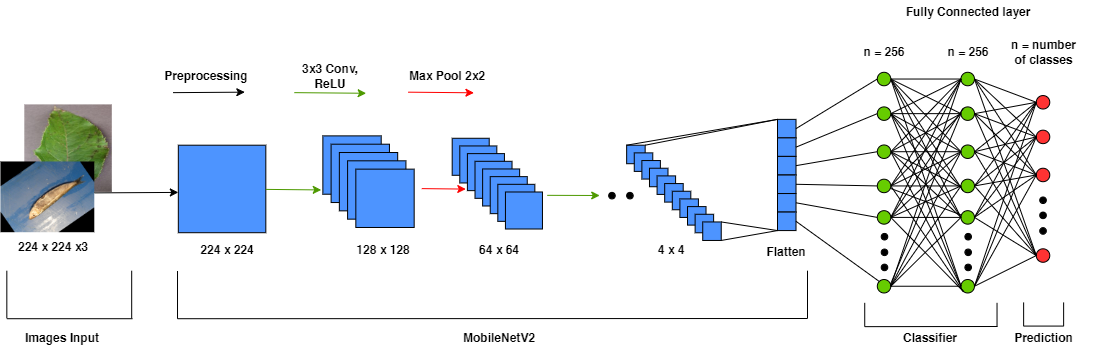

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(38, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "plant_disease_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/plant_disease_classification/20220508-105005
Epoch 1/100
1087/1087 [==============================] - 138s 116ms/step - loss: 1.1747 - accuracy: 0.6916 - val_loss: 0.3808 - val_accuracy: 0.8913
Epoch 2/100
1087/1087 [==============================] - 105s 96ms/step - loss: 0.4116 - accuracy: 0.8773 - val_loss: 0.2365 - val_accuracy: 0.9313
Epoch 3/100
1087/1087 [==============================] - 104s 95ms/step - loss: 0.2871 - accuracy: 0.9103 - val_loss: 0.1928 - val_accuracy: 0.9414
Epoch 4/100
1087/1087 [==============================] - 104s 96ms/step - loss: 0.2303 - accuracy: 0.9284 - val_loss: 0.1628 - val_accuracy: 0.9503
Epoch 5/100
1087/1087 [==============================] - 104s 96ms/step - loss: 0.1914 - accuracy: 0.9394 - val_loss: 0.1520 - val_accuracy: 0.9507
Epoch 6/100
1087/1087 [==============================] - 103s 95ms/step - loss: 0.1623 - accuracy: 0.9493 - val_loss: 0.1387 - val_accuracy: 0.9551
Epoch 7/100
1087/10

## Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11303
Test Accuracy: 96.35%


### Visualizing loss curves

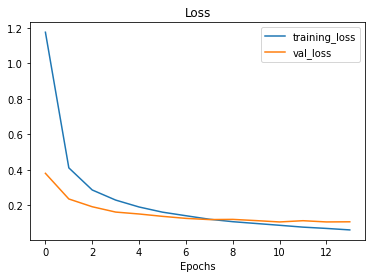

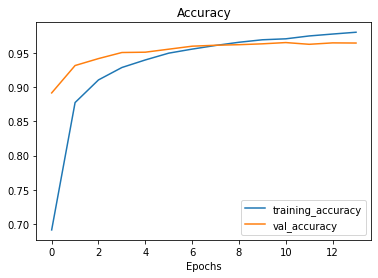

In [ ]:
plot_loss_curves(history)

### Making predictions on the test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Pepper,_bell___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


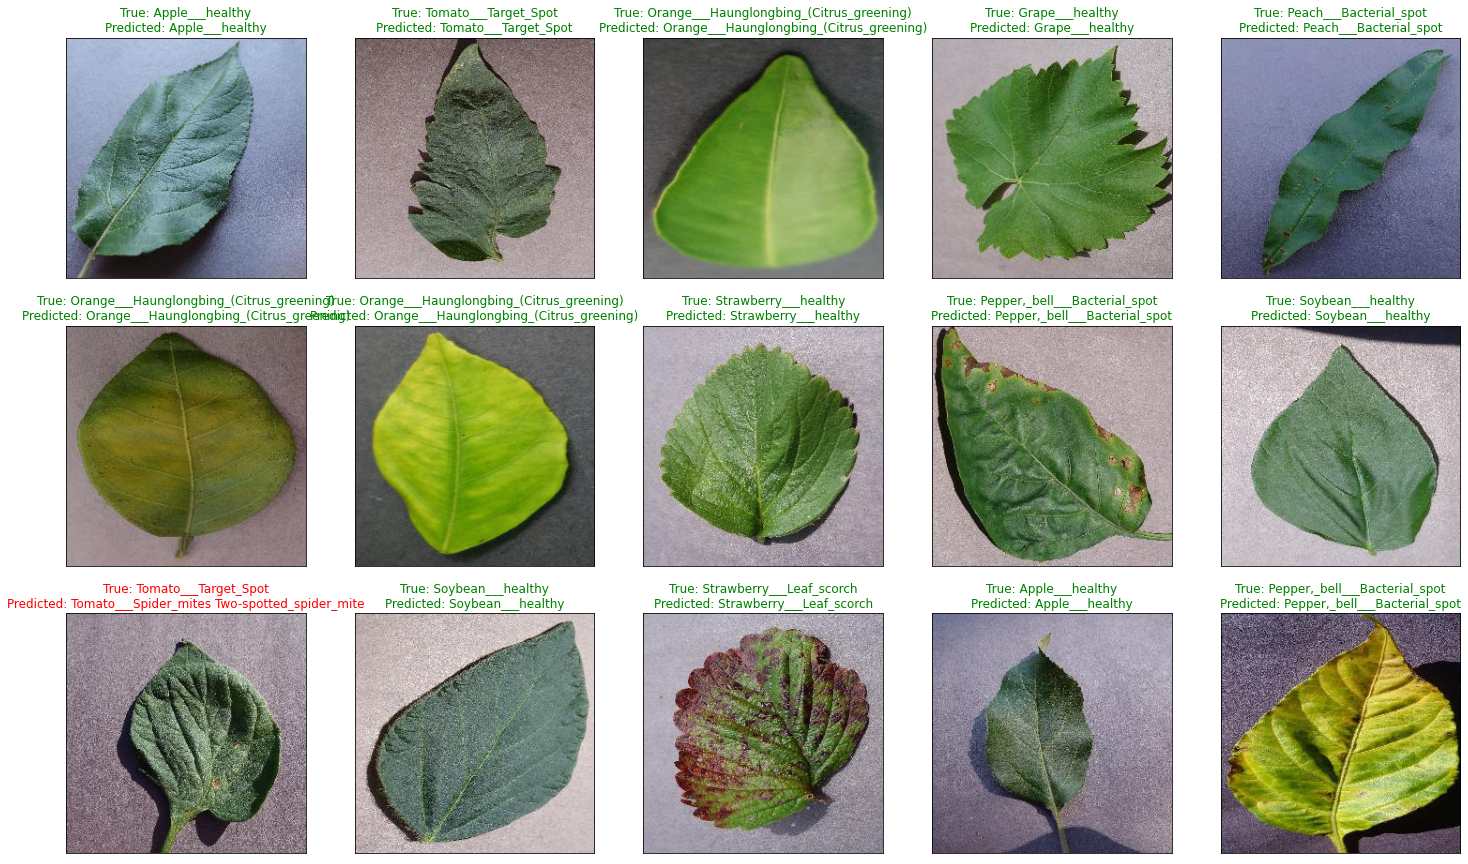

<Figure size 432x288 with 0 Axes>

In [ ]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Plotting the classification reports and confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.81      0.89       124
                                 Apple___Black_rot       0.99      0.98      0.99       128
                          Apple___Cedar_apple_rust       0.96      0.92      0.94        60
                                   Apple___healthy       0.97      1.00      0.98       336
                               Blueberry___healthy       0.99      1.00      0.99       326
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       227
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       180
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.81      0.82       110
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       255
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.90      0.

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Apple___Apple_scab,0.971154,0.814516,0.885965,124.000000
Apple___Black_rot,0.992126,0.984375,0.988235,128.000000
Apple___Cedar_apple_rust,0.964912,0.916667,0.940171,60.000000
Apple___healthy,0.968208,0.997024,0.982405,336.000000
Blueberry___healthy,0.987879,1.000000,0.993902,326.000000
Cherry_(including_sour)___Powdery_mildew,0.995575,0.991189,0.993377,227.000000
Cherry_(including_sour)___healthy,1.000000,0.994444,0.997214,180.000000
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.831776,0.809091,0.820276,110.000000
Corn_(maize)___Common_rust_,0.980769,1.000000,0.990291,255.000000
Corn_(maize)___Northern_Leaf_Blight,0.900000,0.895522,0.897756,201.000000


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


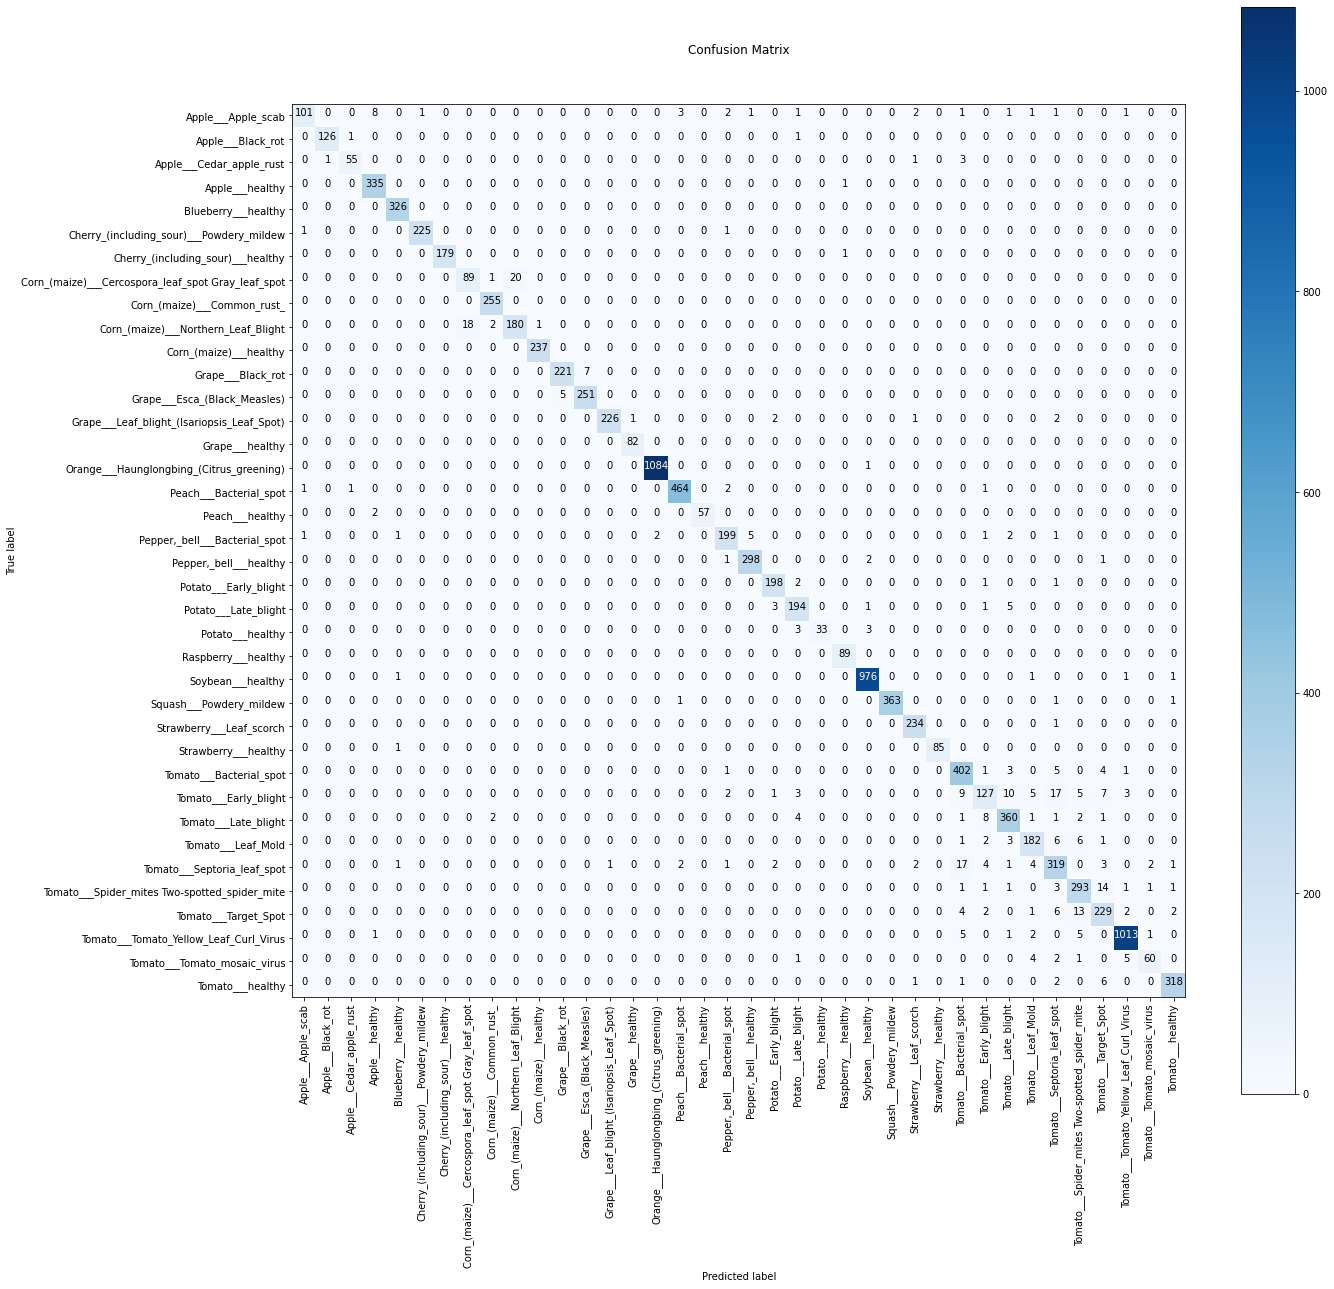

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

### Making predictions on our own images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
filename= "/content/drive/MyDrive/Software Engineering 2/Test Images/corn-leaf-blight.jpg"
image = load_and_prep_image(filename, scale=False)

In [ ]:
pred_prob = model.predict(tf.expand_dims(image, axis=0))
pred_prob.max()

0.31705225

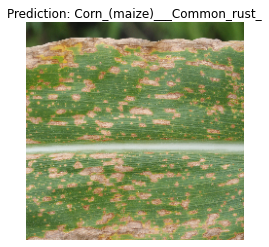

In [ ]:
pred_and_plot(model, filename, list(labels.values()))

In [ ]:
# model.save("/content/drive/MyDrive/Software Engineering 2/Test Images/plant_disease_full_dataset_color.h5")